<a href="https://colab.research.google.com/github/Hiseoi/ETRI2023/blob/main/KOBERT_listen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip3 install transformers
!pip install torchtext==0.11.0
!pip install torchaudio==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp39-cp39-linux_x86_64.whl size=680541 sha256=30e6c11f37422d1715a330f85d5614663f39287fe79e6e3d5cdcbfd1c676fa3f
  Stored in directory: /root/.cache/pip/wheels/47/17/70/b257bc53879a458c4bfcc900e89271aa8b4f19366a54bd2455
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-k2zmhq67
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-k2zmhq67
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
## GPU
device = torch.device("cuda:0")

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
dataset_train = nlp.data.TSVDataset("/content/drive/MyDrive/ETRI/text_set/특수문자 제거/li_traindata.tsv", field_indices=[2,1])
dataset_test = nlp.data.TSVDataset("/content/drive/MyDrive/ETRI/text_set/특수문자 제거/li_testdata.tsv", field_indices=[2,1])

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
#Plot용 학습
losses_train=[];
losses_test=[];
accuracy_train=[];
accuracy_test=[];
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss_a = loss_fn(out, label)
        loss_a.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss_a.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    losses_train.append(loss_a.item())

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss_b = loss_fn(out, label)
        loss_b.backward()
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    losses_test.append(loss_b.item())


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.97320556640625 train acc 0.15625
epoch 1 train acc 0.4439669700033704


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 1 test acc 0.5338278619528619


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.355491042137146 train acc 0.5625
epoch 2 train acc 0.5591453909673071


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 2 test acc 0.6717171717171717


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8884499669075012 train acc 0.71875
epoch 3 train acc 0.6742132204246714


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 3 test acc 0.6767676767676767


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7873870134353638 train acc 0.71875
epoch 4 train acc 0.7231473289518032


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 4 test acc 0.7051241582491582


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.4639420509338379 train acc 0.859375
epoch 5 train acc 0.7615594455679138


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 5 test acc 0.695864898989899


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.5396315455436707 train acc 0.796875
epoch 6 train acc 0.7816133720930233


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 6 test acc 0.6674558080808081


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.4612719416618347 train acc 0.828125
epoch 7 train acc 0.8136427789012471


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 7 test acc 0.6851851851851851


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.46186378598213196 train acc 0.84375
epoch 8 train acc 0.8293362403100775


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 8 test acc 0.6797138047138047


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.31125393509864807 train acc 0.921875
epoch 9 train acc 0.8514071452645771


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 9 test acc 0.6645622895622896


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.2653123438358307 train acc 0.921875
epoch 10 train acc 0.8657945736434108


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 10 test acc 0.6799768518518519


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.2170208990573883 train acc 0.9375
epoch 11 train acc 0.8809350775193798


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 11 test acc 0.6915509259259259


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.24892853200435638 train acc 0.953125
epoch 12 train acc 0.8872335271317829


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 12 test acc 0.6972853535353536


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.17661422491073608 train acc 0.9375
epoch 13 train acc 0.8971656976744186


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 13 test acc 0.6987058080808081


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.11893833428621292 train acc 0.96875
epoch 14 train acc 0.9070978682170543


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 14 test acc 0.6972853535353536


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.095205157995224 train acc 0.984375
epoch 15 train acc 0.9098837209302325


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 15 test acc 0.6830808080808081


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0791659727692604 train acc 0.984375
epoch 16 train acc 0.9131540697674418


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 16 test acc 0.6830808080808081


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.10334392637014389 train acc 0.984375
epoch 17 train acc 0.9185098584428716


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 17 test acc 0.6859217171717172


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.07123882323503494 train acc 0.96875
epoch 18 train acc 0.9232073643410853


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 18 test acc 0.6868686868686869


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.07390588521957397 train acc 0.96875
epoch 19 train acc 0.923812984496124


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 19 test acc 0.6884995791245792


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.06027724966406822 train acc 0.984375
epoch 20 train acc 0.9267199612403101


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 20 test acc 0.6903935185185185


Loss plot

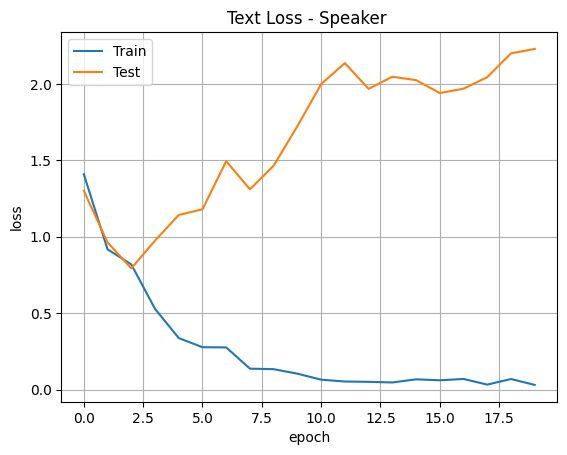

In [ ]:
import matplotlib.pyplot as plt
step_train= num_epochs
plt.title('Text Loss - Speaker ')
plt.plot(range(step_train), losses_train, label ='Train')
plt.plot(range(step_train), losses_test, label='Test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

앙상블을 위한 test 결과 저장

In [ ]:
    test_acc = 0.0
    model.eval()
    result= torch.empty(1,7).cuda()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        A=torch.tensor(out);
        B=A.indices;
        result= torch.cat([result,A], dim=0);
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/33 [00:00<?, ?it/s]

<ipython-input-26-968f37569fb3>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A=torch.tensor(out);


epoch 20 test acc 0.6903935185185185


In [ ]:
liresult= result.cpu()

In [ ]:
liresult

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.2705,  5.1874, -1.1908,  ..., -1.4743, -0.1666, -1.9857],
        [-2.5754, -0.8920,  3.1823,  ...,  0.1304, -2.2820, -1.9690],
        ...,
        [ 2.2714, -2.1572, -1.8640,  ..., -1.6493, -1.9405,  4.2505],
        [-1.1243, -1.8202, -0.7956,  ..., -1.5932, -1.6784,  5.3301],
        [-0.7996, -0.5198, -0.5641,  ..., -1.0618, -2.3638, -1.1768]])

In [ ]:
np.save('/content/drive/MyDrive/ETRI/text_set/liresult', liresult)

In [ ]:
torch.save(model, '/content/drive/MyDrive/ETRI/text_set/limodel.pt')

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/129 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.9834097623825073 train acc 0.140625
epoch 1 train acc 0.4832796174587125


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 1 test acc 0.6063762626262627


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0557392835617065 train acc 0.640625
epoch 2 train acc 0.641846772834513


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 2 test acc 0.7020202020202021


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.645928680896759 train acc 0.8125
epoch 3 train acc 0.7209565638692282


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 3 test acc 0.6903935185185185


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5369889736175537 train acc 0.828125
epoch 4 train acc 0.7714652847994607


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 4 test acc 0.7117529461279462


  0%|          | 0/129 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.31933000683784485 train acc 0.9375
epoch 5 train acc 0.8015040444893833


  0%|          | 0/33 [00:00<?, ?it/s]

epoch 5 test acc 0.7034406565656566
